# Total Variation Denoising problem

## Load modules

In [1]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np
import time

## Load image

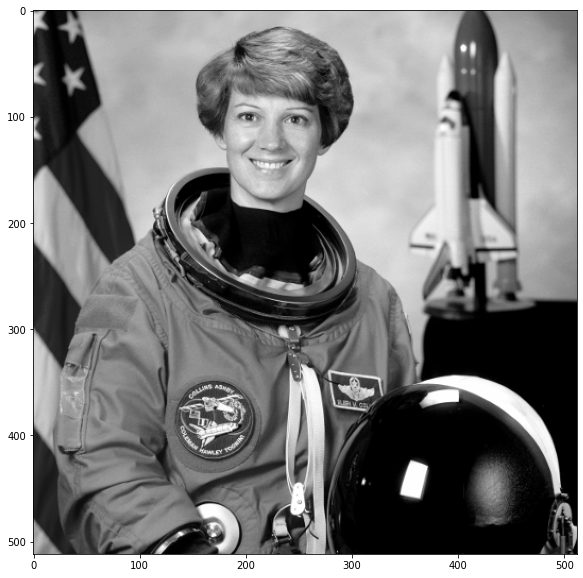

In [2]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]
m = img.shape[1]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Computing the differences operators here.

In [3]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.

from scipy import sparse
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity
 
# Make sure that you compute the right D_h and D_v matrices.

J = sparse.csr_matrix(-identity(n) + diags([1] * (n-1), 1))
I = sparse.csr_matrix(identity(n))

D_h = sparse.csr_matrix(kron(J, I))

D_v = sparse.csr_matrix(kron(I, J))

D = sparse.csr_matrix(D_h + D_v*1j)
D_star = sparse.csr_matrix(np.conj(D).transpose())

print(D_h.shape)
print(D_v.shape)


(262144, 262144)
(262144, 262144)


## Add noise to the image

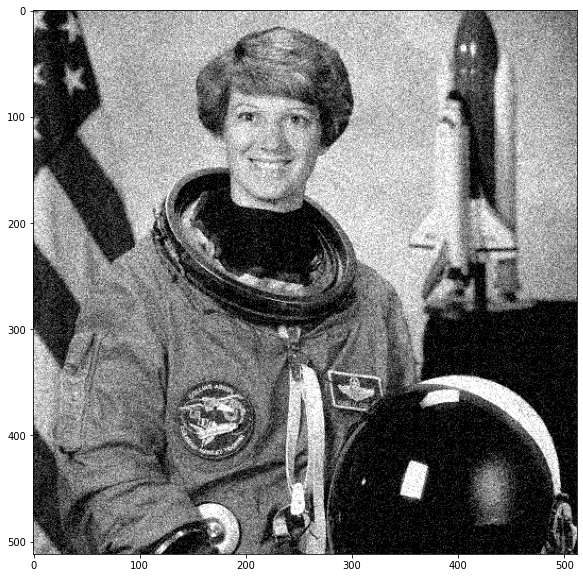

In [4]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise
#turn the noisy image into a vector
vec_z_noisy = noisy_image.transpose().flatten()
vec_z_clean = img.transpose().flatten()

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

# Implementing the gradient descent with Armijo line-search for the Total-Variation denoising problem. I also use the pseudo-Huber function to smooth the problem. 

In [5]:
# Write your code here.
from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
from scipy.sparse.linalg import norm


def obj_fx(x, lambda_, mu): # objective function
    term1 = np.sum(np.sqrt(np.power(abs(D.dot(x)), 2) + mu**2) - mu)
    objective = (lambda_)*(term1) + 0.5 * (LA.norm(x - vec_z_noisy)**2)
    return objective

def grad_fx(x, lambda_, mu): #gradient of the smooth denoising problem
    
    term1 = sparse.csr_matrix(D_h).dot(x)
    term2 = sparse.csr_matrix(D_v).dot(x)
    den = (term1**2 + term2**2 + mu**2)**(-0.5)
    grad_ph = D_h.T.dot(term1*den) + D_v.T.dot(term2*den)
    full_grad = lambda_*grad_ph + x - vec_z_noisy
    return full_grad


def ar_line_search(x, gradient_x, f_x, lambda_, gamma, mu): #armijo line search
    alpha = 1.
    x_new = x - alpha * gradient_x
    fx_new = obj_fx(x_new, lambda_, mu)
    delta = gamma * (LA.norm(gradient_x)**2)
    while fx_new + (alpha * delta) > f_x:
        alpha = alpha / 2.
        x_new = x - alpha * gradient_x
        fx_new = obj_fx(x_new, lambda_, mu)
    return alpha
        
def gradient_descent(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu):
    points = []
    normg = np.zeros(max_iterations+1)
    f_x_list = np.zeros(max_iterations+1)     
    i=0
    num_iter = 0
    x = x0
    
    f_x = obj_fx(x, lambda_, mu) #for the plot
    f_x_list[i] = f_x
    
    gradient_x = grad_fx(x, lambda_, mu)
    grad_norm = LA.norm(gradient_x)
    normg[i] = grad_norm
    
    while grad_norm > epsilon and num_iter < max_iterations:
        alpha = ar_line_search(x, gradient_x, f_x, lambda_, gamma, mu)
        change_term = - alpha * (gradient_x)
        x = x + change_term
        i = i+1        
        f_x = obj_fx(x, lambda_, mu)
        f_x_list[i] = f_x
        gradient_x = grad_fx(x, lambda_, mu)
        grad_norm = LA.norm(gradient_x)
        normg[i] = grad_norm
        num_iter = num_iter + 1
        
    check_error = (1./x.shape[0])*(LA.norm(x-x_clean)) 
    return x, normg, f_x_list, check_error, num_iter

## Implementing Gradient Descent with Armijo line-search to denoise the image. I pick the $\lambda$ parameter that makes the error $$\frac{1}{n^2}\|z_{output} - z_{clean}\|_2$$ as small as possible, where $z_{output}$ is the output of the algorithm. 

## Pick $\mu$ small enough such that the above error does not improve much for smaller values of $\mu$.

Time taken to converge: 197.1483199596405
Error between x_denoised and x_clean 0.019899895733522854


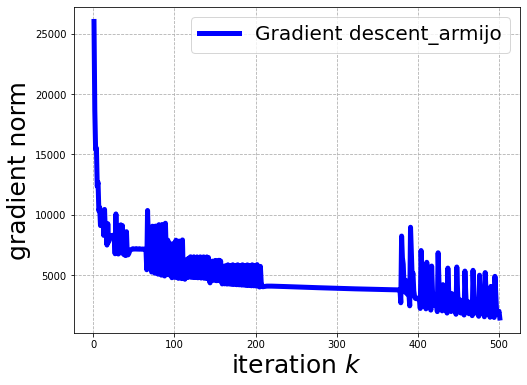

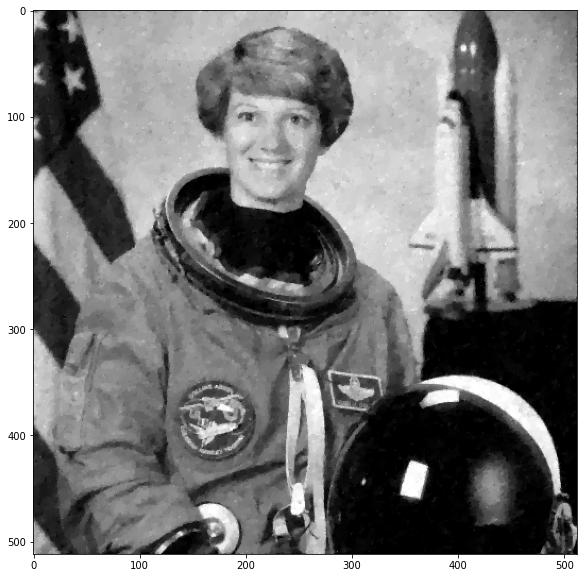

In [6]:
# Initialize parameters of gradient descent
lambda_ = 25
epsilon = 1.0e-2
max_iterations = 500
gamma = 0.5
mu = 0.05

# Set x0 equal to the vectorized noisy image.
x0 = vec_z_noisy
x_clean = vec_z_clean
x = x0

t = time.time()
x_new, normg, f_x_list, error, num_iter_G = gradient_descent(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu)
print ("Time taken to converge:", time.time() - t)

print ("Error between x_denoised and x_clean", error)
normg = np.trim_zeros(normg)
k = np.arange(1,normg.shape[0]+1)

fig = plt.figure(figsize=(8, 6))
plt.plot(k, normg, label=("Gradient descent_armijo"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("gradient norm", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

x_new = np.reshape(x_new, (m, n)) 
x_new = x_new.T
plt.figure(1, figsize=(10, 10))
plt.imshow(x_new, cmap='gray', vmin=0, vmax=255)
plt.show()

## Implementing gradient descent with simple line-search for the Total-Variation denoising problem. I again use the pseudo-Huber function to smooth the problem.

In [7]:

def line_search(x, gradient_x, f_x, lambda_, gamma, mu): #Simple line search
    alpha = 1.
    x_new = x - alpha * gradient_x
    fx_new = obj_fx(x_new, lambda_, mu)
    while fx_new > f_x:
        alpha = alpha / 2.
        fx_new = obj_fx(x - alpha * gradient_x, lambda_, mu)
    return alpha
        
def gradient_descent2(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu):
    points = []
    normg = np.zeros(max_iterations+1)
    f_x_list = np.zeros(max_iterations+1)     
    i=0
    num_iter = 0
    x = x0

    f_x = obj_fx(x, lambda_, mu) #for the plot
    f_x_list[i] = f_x
    
    gradient_x = grad_fx(x, lambda_, mu)
    grad_norm = LA.norm(gradient_x)
    normg[i] = grad_norm
    
    while grad_norm > epsilon and num_iter < max_iterations:
        alpha = line_search(x, gradient_x, f_x, lambda_, gamma, mu)
        change_term = - alpha * (gradient_x)
        x = x + change_term
        i = i+1       
        f_x = obj_fx(x, lambda_, mu)
        f_x_list[i] = f_x
        gradient_x = grad_fx(x, lambda_, mu)
        grad_norm = LA.norm(gradient_x)
        normg[i] = grad_norm
        
        num_iter = num_iter + 1
        
    check_error = (1./x.shape[0])*(LA.norm(x-x_clean)) 
    return x, normg, f_x_list, check_error

Time taken to converge: 201.82626175880432
Error between x_denoised and x_clean 0.0196777538353971


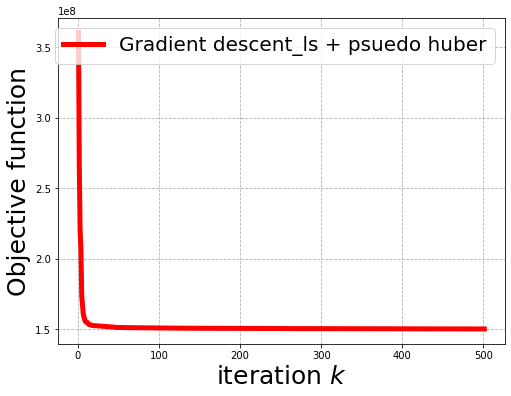

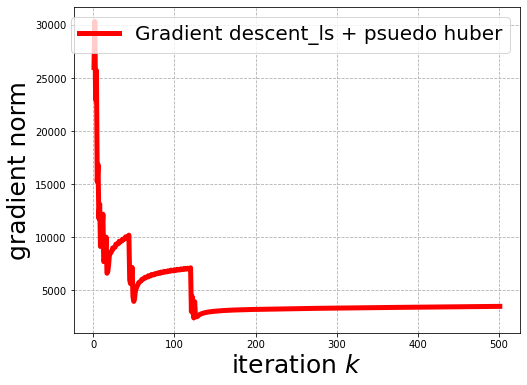

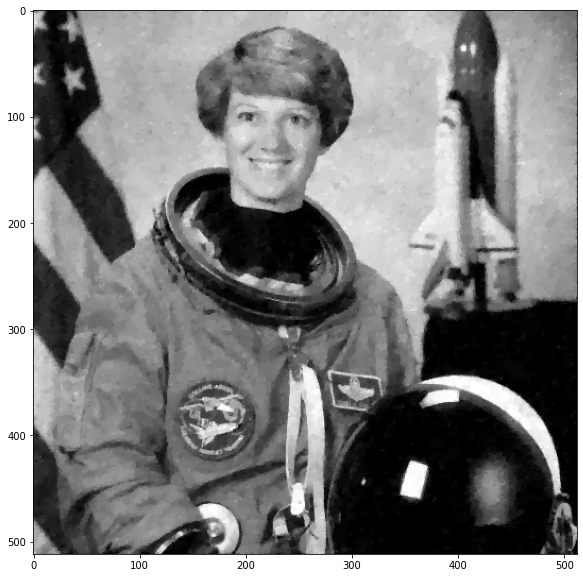

In [8]:
# write your code here

# Initialize parameters of gradient descent
lambda_ = 25
epsilon = 1.0e-2
max_iterations = 500
gamma = 0.5
mu = 0.05

# Set x0 equal to the vectorized noisy image.
x0 = vec_z_noisy
x_clean = vec_z_clean

t = time.time()
x_new2, normg2, f_x_list2, error2 = gradient_descent2(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu)
print ("Time taken to converge:", time.time() - t)

print ("Error between x_denoised and x_clean", error2)
normg2 = np.trim_zeros(normg2)
k = np.arange(1,normg2.shape[0]+1)

fig = plt.figure(figsize=(8, 6))
plt.plot(k, f_x_list2, label=("Gradient descent_ls + psuedo huber"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot(k, normg2, label=("Gradient descent_ls + psuedo huber"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("gradient norm", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

x_new2 = np.reshape(x_new2, (m, n)) 
x_new2 = x_new2.T
plt.figure(1, figsize=(10, 10))
plt.imshow(x_new2, cmap='gray', vmin=0, vmax=255)
plt.show()

## Computing a Lipschitz constant for the smoothed Total-Variation problem. 

#### Note the Lipschitz constant is not unique. However, the minimum Lipschitz constant will give us the better performance in algorithms compared to larger Lipschitz constants. 

In [9]:
from scipy.sparse import coo_matrix, vstack

# Initialize parameters of gradient descent
lambda_ = 25
mu = 0.05

l_s_time = time.time()
    
stack_D = vstack([D_h, D_v]) #stacking Dh on top of Dv
print(stack_D.shape)
stack_Dconj = sparse.csr_matrix(np.conj(stack_D).transpose())
feed = stack_Dconj.dot(stack_D)

eigenvalues = eigsh(feed, return_eigenvectors = False) #calculating Lipschitz constant
max_ev = np.amax(np.array(eigenvalues)) #taking the max eigenvalue
lip_constant = lambda_*max_ev/mu + 1 #Lipschitz constant   

l_e_time = time.time()
l_time_taken = l_e_time - l_s_time

print("Lipschitz constant is:", lip_constant)
print("Time taken to compute Lipschitz constant is ", l_time_taken, "seconds") 


(524288, 262144)
Lipschitz constant is: 4000.962423991211
Time taken to compute Lipschitz constant is  523.9880571365356 seconds


## Implementing accelerated gradient for the Total-Variation denoising problem using the pseudo-Huber function to smooth the proble and the Lipschitz constant that we calculated before 

In [10]:
def acc_grad_descent(l_constant, x0, x_clean, epsilon, lambda_, max_iterations, mu):
    
    normg = np.zeros(max_iterations)
    error = np.zeros(max_iterations)
    f_x_list = np.zeros(max_iterations) 
    
    x = x0
    gamma = 0
    lam = 1
    z = x0    
    i = 0
    
    f_x = obj_fx(x, lambda_, mu) #for the plot
    f_x_list[i] = f_x
    
    gradient_x = grad_fx(x, lambda_, mu)
    grad_norm = LA.norm(gradient_x)
    normg[i] = grad_norm
    error[i] = (1./x.shape[0])*(LA.norm(x-x_clean)) 
    
    i = i+1
    while grad_norm > epsilon and i < max_iterations:
        if i < 4:
            gamma = 0.            
        else:
            gamma = 2./i           
        lam = (1 - gamma)*lam        
        y = (1 - gamma)*x + gamma*z
        grad_y = (1./l_constant)*grad_fx(y, lambda_, mu)
        z = z - gamma/lam*grad_y
        x = y - grad_y
        gradient_x = grad_fx(x, lambda_, mu)
        grad_norm = LA.norm(gradient_x)
        normg[i] = grad_norm
        f_x = obj_fx(x, lambda_, mu)
        f_x_list[i] = f_x
        error[i] = (1./x.shape[0])*(LA.norm(x-x_clean))
        i=i+1
    return x, normg, f_x_list, error, i

Time taken to converge: 75.57853078842163
Error between x_denoised and x_clean 0.019790617137850245


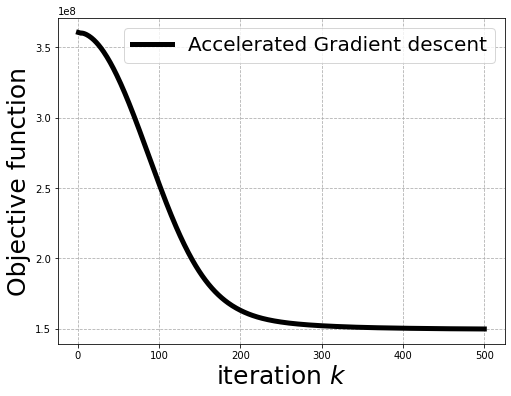

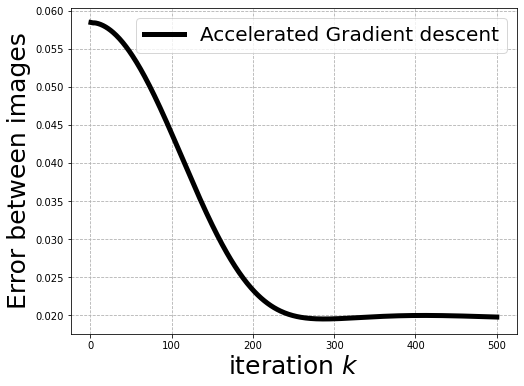

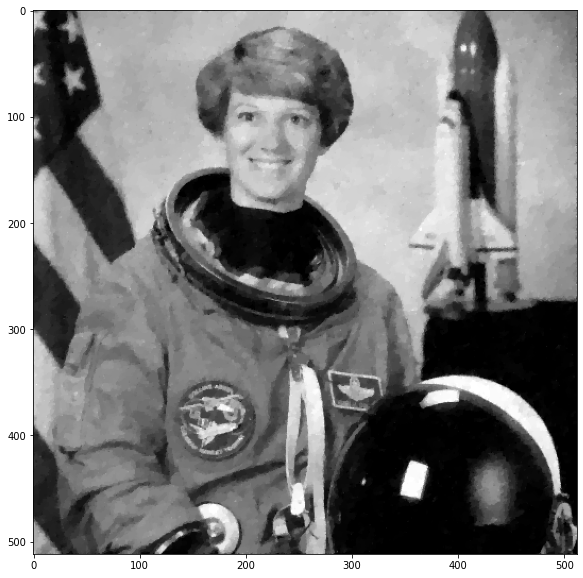

In [11]:
# write your code here

# Initialize parameters of gradient descent
lambda_ = 25
epsilon = 1.0e-2
max_iterations = 500
mu = 0.05
gamma = 0.5

l_constant = 4000.96

# Set x0 equal to the vectorized noisy image.
x0 = vec_z_noisy
x_clean = vec_z_clean

t = time.time()
x_new3, normg3, f_x_list3, error3, num_iter_AG = acc_grad_descent(l_constant, x0, x_clean, epsilon, lambda_, max_iterations, mu)
print ("Time taken to converge:", time.time() - t)

print ("Error between x_denoised and x_clean", error3[-1])
error3 = np.trim_zeros(error3)
k = np.arange(1,error3.shape[0]+1)

fig = plt.figure(figsize=(8, 6))
plt.plot(k, f_x_list3, label=("Accelerated Gradient descent"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot(k, error3, label=("Accelerated Gradient descent"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Error between images", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

x_new3 = np.reshape(x_new3, (m, n)) 
x_new3 = x_new3.T
plt.figure(1, figsize=(10, 10))
plt.imshow(x_new3, cmap='gray', vmin=0, vmax=255)
plt.show()

## In previous algorithms I implemented accelerated gradient by using constant step-sizes $1/L.$ However, computing the Lipschitz constant might take a lot of time and it often results in slow convergence because the step-sizes are too small. Below is the practical accelerated method that does not require knowing the Lipschitz constant. The step-sizes $$\alpha_k$$ in this algorithm can be computed using Armijo line-search. I  now implement this algorithm for the Total-Variation denoising problem using the pseudo-Huber function to smooth the problem. 

Step 1) Choose an $x_0$ and set $y_1=x_0$, $t_1=1$.

Step 2) Repeat the following steps until $\|\nabla f(x_k)\|_2\le \epsilon$

Step 3) Compute $\alpha_k$ using Armijo line-search. Armijo line-search should be measured at $y_k-\alpha_k \nabla f(y_k)$ (as the next point) and $y_k$ (as the current point).

Step 4) Set $$x_{k}=y_k - \alpha_k \nabla f(y_k)$$

Step 5) Set $$t_{k+1}=\frac{1 + \sqrt{1+4t_k^2}}{2}$$

Step 6) Set $$y_{k+1}=x_k + \frac{t_k-1}{t_{k+1}}(x_k-x_{k-1})$$

Reference: this algorithm is given in "A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems" by A. Beck and M. Teboulle.
===================== 

In [12]:
def pract_acc_grad(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu):
    
    normg = np.zeros(max_iterations)
    error = np.zeros(max_iterations+1)
    f_x_list = np.zeros(max_iterations+1) 
    
    i=0
    num_iter = 0
    y = x0
    x = x0
    t = 1.
    x_prev = x0
    t_prev = t
    
    f_y = obj_fx(y, lambda_, mu)
    gradient_y = grad_fx(y, lambda_, mu)
    
    f_x = obj_fx(x, lambda_, mu)
    f_x_list[i] = f_x
    
    gradient_x = grad_fx(x, lambda_, mu)
    grad_norm = LA.norm(gradient_x)
    error[i] = (1./x0.shape[0])*(LA.norm(x-x_clean)) 
    
    i = i+1     
    while grad_norm > epsilon and num_iter < max_iterations:
        
        alpha = ar_line_search(y, gradient_y, f_y, lambda_, gamma, mu)
        change_term = - alpha * (gradient_y)
        x = y + change_term
        t = (1+(1+4*(t)**2)**(0.5))/2.
        y = x + ((t_prev-1)/t)*(x - x_prev)
                      
        f_y = obj_fx(y, lambda_, mu)
        gradient_y = grad_fx(y, lambda_, mu)
        
        f_x = obj_fx(x, lambda_, mu)
        f_x_list[i] = f_x
        
        gradient_x = grad_fx(x, lambda_, mu)
        grad_norm = LA.norm(gradient_x)

        error[i] = (1./x0.shape[0])*(LA.norm(x-x_clean)) 
        t_prev = t
        x_prev = x
        num_iter = num_iter + 1
        i = i+1  
        
    return x, normg, f_x_list, error, num_iter

Time taken to converge: 270.124986410141
Error between x_denoised and x_clean 0.019593257561717342


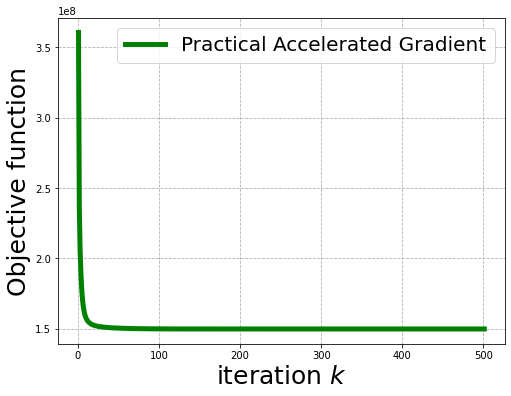

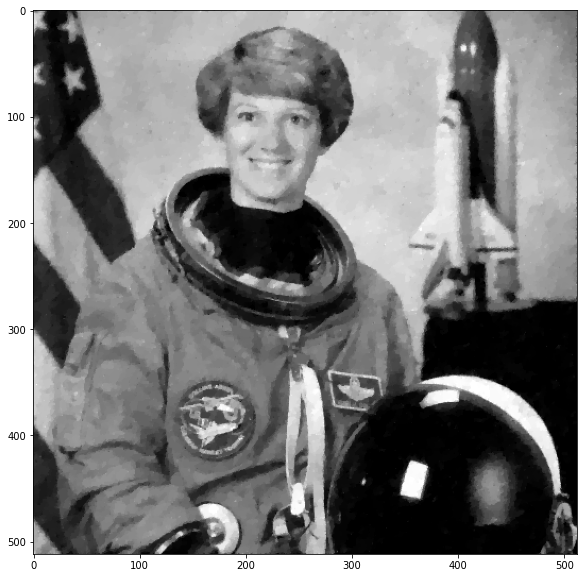

In [13]:

# Initialize parameters of gradient descent
lambda_ = 25
epsilon = 0.01
max_iterations = 500
gamma = 0.5
mu = 0.05

# Set x0 equal to the vectorized noisy image.
x0 = vec_z_noisy
x_clean = vec_z_clean

t = time.time()
x_new4, normg4, f_x_list4, error4, num_iter_PGD_LS = pract_acc_grad(x0, x_clean, epsilon, lambda_, max_iterations,gamma, mu)
print ("Time taken to converge:", time.time() - t)

error4 = np.trim_zeros(error4)
print ("Error between x_denoised and x_clean", error4[-1])
k = np.arange(1,f_x_list4.shape[0]+1)

fig = plt.figure(figsize=(8, 6))
plt.plot(k, f_x_list4, label=("Practical Accelerated Gradient"), linewidth=5.0, color ="green")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

x_new4 = np.reshape(x_new4, (m, n)) 
x_new4 = x_new4.T
plt.figure(1, figsize=(10, 10))
plt.imshow(x_new4, cmap='gray', vmin=0, vmax=255)
plt.show()

## Below I compare all the methods that I implemented above. 

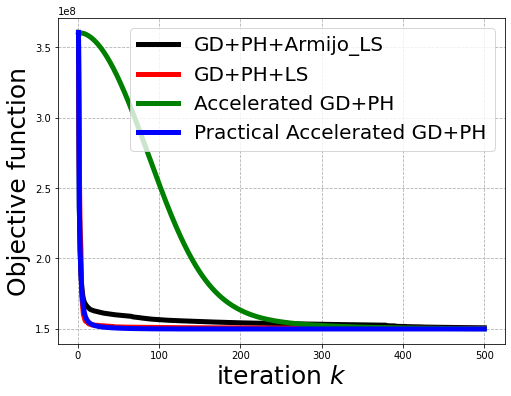

In [14]:
# Write your code here.
# Initialize parameters of gradient descent
lambda_ = 25
epsilon = 1.0e-2
max_iterations = 500
gamma = 0.5
mu = 0.05

l_constant = 4000.96

#x_new, normg, f_x_list, error = gradient_descent(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu)
#x_new2, normg2, f_x_list2, error2 = gradient_descent2(x0, x_clean, epsilon, lambda_, max_iterations, gamma, mu)
#x_new3, normg3, f_x_list3, error3 = acc_grad_descent(l_constant, x0, x_clean, epsilon, lambda_, max_iterations, mu)
#x_new4, normg4, f_x_list4, error4 = pract_acc_grad(x0, x_clean, epsilon, lambda_, max_iterations,gamma, mu)

#print(f_x_list.shape)
#print(f_x_list2.shape)
#print(f_x_list3.shape)
#print(f_x_list4.shape)

plot1 = f_x_list[:-1]
plot2 = f_x_list2[:-1]
plot3 = f_x_list3
plot4 = f_x_list4[:-1]

k_x = np.arange(1,plot2.shape[0]+1)

fig = plt.figure(figsize=(8, 6))
plt.plot(k_x, plot1, label=("GD+PH+Armijo_LS"), linewidth=5.0, color ="black")
plt.plot(k_x, plot2, label=("GD+PH+LS"), linewidth=5.0, color ="red")
plt.plot(k_x, plot3, label=("Accelerated GD+PH"), linewidth=5.0, color ="green")
plt.plot(k_x, plot4, label=("Practical Accelerated GD+PH"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
